# Cat or Dog - Deep Learning

## Bibliotecas

In [86]:
import os
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Download dataset e criando as pastas (train e validation)

In [87]:
# URL of the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download the dataset
def download_dataset(url, filename):
    """
    Download the dataset from the given URL and save it to the specified filename.
    """
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"Dataset downloaded and saved as {filename}")
    except Exception as e:
        print(f"Error downloading dataset: {e}")

# Extract the dataset
def extract_dataset(filename, extract_dir):
    """
    Extract the contents of the downloaded ZIP file to the specified directory.
    """
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Dataset extracted to {extract_dir}")
    except Exception as e:
        print(f"Error extracting dataset: {e}")

# Set the filename and extract directory
filename = 'cats_and_dogs.zip'
extract_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download and extract the dataset
download_dataset(_URL, filename)
extract_dataset(filename, extract_dir)


Dataset downloaded and saved as cats_and_dogs.zip
Dataset extracted to c:\Users\saulo\OneDrive\Documentos\cat_or_dog\cats_and_dogs_filtered


1. ***train_dir*** - Pasta contendo imagens para treinamento

In [88]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/train'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


2. ***validation_dir*** - Pasta contendo imagens para validação

In [89]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

validation_dir = 'cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Algumas imagens da base de treinamento

- Nove imagens e rótulos do conjunto de treinamento:

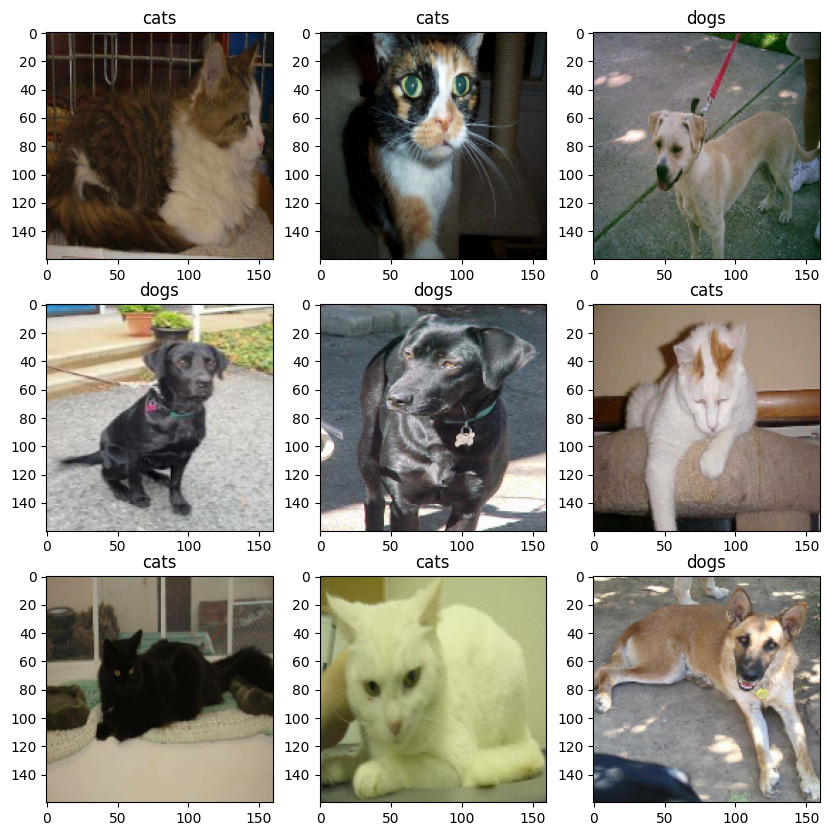

In [90]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

Como o conjunto de dados original não contém um conjunto de teste, criaremos um.

Para fazer isso, determinei quantos lotes de dados estão disponíveis no conjunto de validação usando *tf.data.experimental.cardinality* e movi 20% deles para um conjunto de teste.

In [91]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [92]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Data augmentation

Link para o ipynb
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br#data_download